# Bài toán phân loại sử dụng SVM 


Mục tiêu: 

- Xây dựng được mô hình svm sử dụng thư viện sklearn. 
- Ứng dụng, hiểu cách áp dụng mô hình svm vào giải quyết bài toán thực tế (vd: phân loại tin tức dạng văn bản) .
- Sử dụng độ đo Accuracy để làm độ đo đánh giá chất lượng mô hình. 

Vấn đề: 

- Có một tập các văn bản dạng text không có nhãn, làm sao để biết văn bản này là thuộc về thể loại nào, pháp luật, đời sống, văn học, thể thao ...
- Cần xây dựng mô hình học máy phân loại các thể loại của văn bản dựa trên nội dung.  

Dữ liệu: 

- Có tập các văn bản và nhãn tương ứng của từng văn bản trong một khoảng thời gian 
- Tập các nhãn - 10 nhãn văn bản: 
    > Giải trí, Khoa học - Công nghệ, Kinh tế, Pháp luật, Sức khỏe, Thể thao, Thời sự, Tin khác, Độc giả, Đời sống - Xã hội
- Ví dụ văn bản nhãn **thể thao**: 
    > "Dân_trí Real Madrid đã dẫn trước trong cả trận đấu , nhưng họ vẫn phải chấp_nhận bị Dortmund cầm hòa 2-2 ở Bernabeu . Real Madrid chấp_nhận đứng thứ_hai ở bảng F Champions League ..."

Bài toán: 

- Input: tập các từ trong văn bản 1 mẫu dữ liệu $X = [x_1, x_2, ... x_n]$
- Output: nhãn $y$ là 1 trong 10 nhãn trên 

In [1]:
# Cài đặt thư viện xử lý ngôn ngữ cho tiếng Việt!
!pip install pyvi


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [22]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_files
from pyvi import ViTokenizer


from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

%matplotlib inline

## 1. Sử dụng sklearn.datasets.load_files để load dữ liệu từ thư mục đã down từ trước

Cấu trúc thư mục như sau 

- data/news_1135/

    - Kinh tế: 
        - bài báo 1.txt 
        - bài báo 2.txt 
    - Pháp luật
        - bài báo 3.txt 
        - bài báo 4.txt 

In [23]:
data_train = load_files(container_path="data/news_1135/", encoding="utf-8")

print(data_train.filenames)
print()

print("Tong so file: {}" .format( len(data_train.filenames)))
print("Danh sách nhãn và id tương ứng: ", [(idx, name) for idx, name in enumerate(data_train.target_names)] )


['data/news_1135/Pháp luật/0e7537e00a4dd4c8c1b8d786858885c920311800.txt'
 'data/news_1135/Thời sự/7ea376282b8acc4cb3784dbaa9fa995b52e57ce1.txt'
 'data/news_1135/Thể thao/e78ef641b159653587e011d5929935b33e78c8d8.txt'
 ...
 'data/news_1135/Tin kh†c/79a417e6e6db3325e0a9485fe4e7ed504f526ec7.txt'
 'data/news_1135/Thể thao/5ee1dd38f31f2c61aa851907eddbc3d84dbad1b4.txt'
 'data/news_1135/Thời sự/4d983a17cb022cdb89d9ddcdfe6475b32f4673e1.txt']

Tong so file: 1027
Danh sách nhãn và id tương ứng:  [(0, 'Giải trí'), (1, 'Khoa học - Công nghệ'), (2, 'Kinh tế'), (3, 'Pháp luật'), (4, 'Sức khỏe'), (5, 'Thể thao'), (6, 'Thời sự'), (7, 'Tin kh†c'), (8, 'Độc giả'), (9, 'Đời sống - Xã hội')]


###  Tiền xử lý dữ liệu đưa dữ liệu từ dạng text về dạng ma trận 

- Thử nghiệm để kiểm tra hoạt động chuyển hoá dữ liệu về dạng ma trận 

In [24]:
# load dữ liệu các stopwords 
with open("data/vietnamese-stopwords.txt",encoding="utf-8") as f:
    stopwords = f.readlines()
stopwords = [x.strip().replace(" ", "_") for x in stopwords] 
print("Danh sách 10 từ dừng đầu tiên (từ không mang ý nghĩa phân loại): ", stopwords[:10])

# Transforming data 
# Chuyển hoá dữ liệu text về dạng vector tfidf 
#     - loại bỏ từ dừng
#     - sinh từ điển
module_count_vector = CountVectorizer(stop_words=stopwords)
model_rf_preprocess = Pipeline([('vect', module_count_vector),
                    ('tfidf', TfidfTransformer()),
                    ])
# Hàm thực hiện chuyển đổi dữ liệu text thành dữ liệu số dạng ma trận 
# Input: Dữ liệu 2 chiều dạng numpy.array, mảng nhãn id dạng numpy.array 
data_preprocessed = model_rf_preprocess.fit_transform(data_train.data, data_train.target)
print("10 từ đầu tiên trong từ điển:")
i = 0
for k,v in module_count_vector.vocabulary_.items():
    i+=1
    print(i, ": ", (k, v))
    if i > 10:
        break 

Danh sách 10 từ dừng đầu tiên (từ không mang ý nghĩa phân loại):  ['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']
10 từ đầu tiên trong từ điển:
1 :  ('dân_trí', 6637)
2 :  ('trình_báo', 18949)
3 :  ('sống', 17035)
4 :  ('lâu_năm', 11077)
5 :  ('chùa', 4684)
6 :  ('chiều', 4401)
7 :  ('tượng', 19801)
8 :  ('phật', 14925)
9 :  ('chánh', 4551)
10 :  ('điện', 22142)
11 :  ('nam', 12684)


### Bài 1: Sử dụng trực tiếp TfidfVectorizer()
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [25]:
# Chú ý: có thể biến đổi dữ liệu về dạng Tf-Idf trực tiếp sử dụng TfidfVectorizer()
# Bài tập: 
# - thực hiện điều đó
# - hiển thị 10 từ trong văn bản đầu tiên có giá trị tfidf cao nhất
# code
vectorizer = TfidfVectorizer(stop_words=stopwords)
data_tfidf = vectorizer.fit_transform(data_train.data)
print(type(data_tfidf))

words = vectorizer.get_feature_names_out()
print(type(words), words)

first_doc = data_tfidf[0].toarray().flatten()
print(first_doc.shape)

sorted_tfidf = np.sort(first_doc)[::-1]
sorted_idx = first_doc.argsort()[::-1] #return idx, des
top10_id = sorted_idx[:10]
for id in top10_id:
    print(words[id], first_doc[id])

<class 'scipy.sparse._csr.csr_matrix'>
<class 'numpy.ndarray'> ['00' '000' '0000' ... 'ứng_viên' 'ứng_xử' 'ỷ_lại']
(23343,)
chùa 0.40240861872588835
tượng 0.31647969464881753
trình_báo 0.24144517123553305
vàng 0.20097792849811671
phật 0.19536838237128315
công_an 0.19386508051179627
đục 0.1871475297626935
thủ_đức 0.18077094108520872
cột 0.17115585231526417
cất_giấu 0.17115585231526417


### Chia dữ liệu làm 2 phần training và testing 

- Training chiếm 80 % dữ liệu 
- Testing chiếm 20 % dữ liệu 

In [26]:
from sklearn.model_selection import ShuffleSplit

# chia dữ liệu thành 2 phần sử dụng hàm train_test_split.
test_size = 0.2
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split( data_preprocessed, data_train.target, test_size=test_size)

# hiển thị một số thông tin về dữ liệu 
print("Dữ liệu training: ", X_train.shape, y_train.shape)
print("Dữ liệu testing: ", X_test.shape, y_test.shape)
print("Danh sách nhãn và id tương ứng: ", [(idx, name) for idx, name in enumerate(data_train.target_names)] )

Dữ liệu training:  (821, 23343) (821,)
Dữ liệu testing:  (206, 23343) (206,)
Danh sách nhãn và id tương ứng:  [(0, 'Giải trí'), (1, 'Khoa học - Công nghệ'), (2, 'Kinh tế'), (3, 'Pháp luật'), (4, 'Sức khỏe'), (5, 'Thể thao'), (6, 'Thời sự'), (7, 'Tin kh†c'), (8, 'Độc giả'), (9, 'Đời sống - Xã hội')]


## 2. Training svm model 

Sử dụng thư viện sklearn để xây dựng mô hình
-  Thử trước với hàm nhân phân tách là Linear, tham số C=1.0
- `svm.SVC(kernel='linear', C=1.0)`
 

In [27]:
print("- Training ...")
print("- Train size = {}".format(X_train.shape))
model = svm.SVC(kernel='linear', C=1) #use hyperplane
model.fit(X_train, y_train)
print("- model - train complete")


- Training ...
- Train size = (821, 23343)
- model - train complete


## 3. Testing svm model 

Thực hiện dự đoán nhãn cho từng văn bản trong tập test 

Độ đo đánh giá: 
> accuracy = tổng số văn bản dự đoán đúng  / tổng số văn bản có trong tập test  

In [28]:
from sklearn.metrics import accuracy_score
print("- Testing ...")
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
print("- Test Acc = {}".format(accuracy_score(y_test, y_test_pred)))
print("- Train Acc = {}".format(accuracy_score(y_train, y_train_pred)))


- Testing ...
- Test Acc = 0.9029126213592233
- Train Acc = 0.9939098660170523


### Bài 2: thực hiện lại các bước trên với kernel = 'rbf'

In [29]:
# code
model_rbf = svm.SVC(kernel='rbf', C=2)
model_rbf.fit(X_train, y_train)

y_test_rbf_pred = model_rbf.predict(X_test)
y_train_rbf_pred = model_rbf.predict(X_train)

print("- Test Acc = {}".format(accuracy_score(y_test, y_test_rbf_pred)))
print("- Train Acc = {}".format(accuracy_score(y_train, y_train_rbf_pred)))


- Test Acc = 0.8495145631067961
- Train Acc = 1.0


#### Đặc trưng của dataset là sparse và high dimension
 * Linear: K = <x, z>: 2 văn bản x và z có nhiều từ chung thì K lớn
 * RBF: K = exp(-||x - z ||^2 / 2sigma), RBF không cho đặc trưng tốt với sparse data, ví dụ x = (0, 0, 5, 10), z = (2, 2, 0, 1) thì K vẫn rất cao dù x và z chả chung gì mấy

### 3.1. Thực hiện sử dụng model đã được train để infer 1 văn bản mới 
- Dữ liệu mới đến ở dạng dữ liệu thô => cần tiền xử lý dữ liệu về dạng dữ_liệu_ma_trận
- infer sử dụng hàm model.predict(dữ_liệu_ma_trận) 

In [30]:
# Tiền xử lý dữ liệu sử dụng module model_rf_preprocess. 
new_doc = "Công phượng ghi bàn cho đội tuyển Việt nam"
# Trước hết, cần thực hiện tách từ sử dụng pyvi
tokenized_new_doc = ViTokenizer.tokenize(new_doc)
# Cần đưa văn bản ở dạng mảng/vector
tokenized_new_doc = [tokenized_new_doc]
print(tokenized_new_doc)
# Rồi sử dụng module model_rf_preprocess
input_data_preprocessed = model_rf_preprocess.transform(tokenized_new_doc)
print(input_data_preprocessed)

['Công phượng ghi_bàn cho đội_tuyển Việt_nam']
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5 stored elements and shape (1, 23343)>
  Coords	Values
  (0, 5604)	0.3259420645757043
  (0, 7434)	0.4571409262822909
  (0, 14857)	0.6494454479437373
  (0, 20576)	0.23243650255677087
  (0, 23104)	0.4571409262822909


### Bài 3: dự đoán nhãn của văn bản trên

In [31]:
# code
y_pred_exp1 = model.predict(input_data_preprocessed)
print(y_pred_exp1, data_train.target_names[y_pred_exp1[0]])

y_pred_exp2 = model_rbf.predict(input_data_preprocessed)
print(y_pred_exp2, data_train.target_names[y_pred_exp2[0]])


[5] Thể thao
[5] Thể thao


## 4. Bài tập bổ sung: 

### 4.1 Thử nghiệm các tham số 

- Các tham số với giá trị khác nhau có thể ảnh hưởng để kết quả học 
- Cần thử nghiệm kỹ lượng để đưa ra kết quả khách quan: tham số C, gamma, kernel. 
    - Chọn mô hình với bộ tham số cho kết quả tốt nhất 
- Gợi ý: 
    - https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    - Sử dụng grid search

#### Bài 4: Vẽ Learning curve khảo sát Acc của SVM-linear với tham số C thay đổi

In [36]:
# code
# tham khảo miền của C
acc_test = []
acc_train = []
list_C = [0.001, 0.01, 0.1, 1, 5.0, 10.0, 100]
for C in list_C:
    SVM = svm.SVC(kernel='linear', C=C)
    SVM.fit(X_train, y_train)
    y_pred_test = SVM.predict(X_test)
    y_pred_train = SVM.predict(X_train)
    acc_test.append(accuracy_score(y_test, y_pred_test) * 100)
    acc_train.append(accuracy_score(y_train, y_pred_train) * 100)

print(acc_test)
print(acc_train)

[17.96116504854369, 17.96116504854369, 36.89320388349515, 90.29126213592234, 91.2621359223301, 90.77669902912622, 86.89320388349515]
[19.366626065773445, 19.366626065773445, 43.72716199756395, 99.39098660170524, 100.0, 100.0, 100.0]


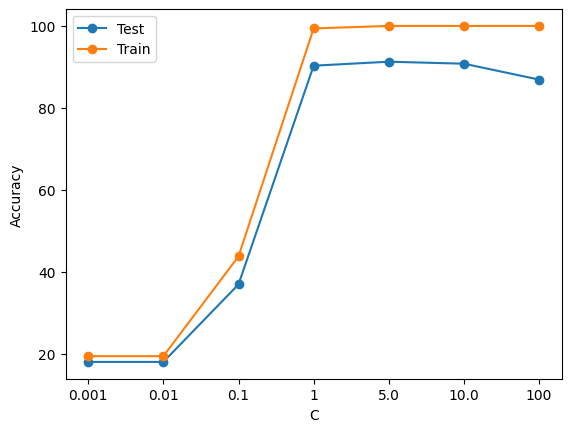

In [41]:
x = np.arange(len(list_C))
plt.plot(x, acc_test, marker = 'o', label='Test')
plt.plot(x, acc_train, marker = 'o', label='Train')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(x, [str(C) for C in list_C])
plt.show()

#### Bài 5: Sử dụng GridSearchCV để tìm bộ tham số tốt nhất

In [45]:
# code
# Có thể tham khảo giá trị các tham số như sau
params_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
          'gamma': [0.0001, 0.001, 0.01, 0.1],
          'kernel':['linear','rbf', 'poly'] }

gridSearchCV = GridSearchCV(estimator=svm.SVC(), param_grid=params_grid,scoring='accuracy',
                            n_jobs=-1, cv=5)
gridSearchCV.fit(X_train, y_train)

best_model = gridSearchCV.best_estimator_
print(best_model)

SVC(C=1, gamma=0.0001, kernel='linear')


### 4.2 Phân loại số viết tay 

(1797, 8, 8)
Dữ liệu training =  (1437, 64) (1437,)
Dữ liệu testing =  (360, 64) (360,)


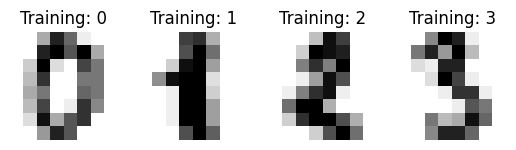

In [49]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest') #zoom picture: new pixel = nearest pixel
    plt.title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
print(digits.images.shape)
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1)) #flatten
target = digits.target
X_train, X_test, y_train, y_test = train_test_split( data, target, test_size=test_size)

print("Dữ liệu training = ", X_train.shape, y_train.shape)
print("Dữ liệu testing = ", X_test.shape, y_test.shape)


#### Bài 6: phân loại với dữ liệu trên

In [59]:
##### exercise #####
# Yêu cầu: Ứng dụng mô hình svm vào bài toán phân loại ảnh 
# Gợi ý: dữ liệu đã được chia train, test, Áp dụng phần 2. và 3. để training và testing model. Chú ý nên có thêm phần tuning model
######################

# model = None
######################
params_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
          'gamma': [0.0001, 0.001, 0.01, 0.1],
          'kernel':['linear','rbf', 'poly'] }

gridSearchCV = GridSearchCV(estimator=svm.SVC(), param_grid=params_grid,scoring='accuracy',
                            n_jobs=-1, cv=5)
gridSearchCV.fit(X_train, y_train)

best_model = gridSearchCV.best_estimator_
print(best_model)
print(best_model.kernel)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print(f'Training set: {accuracy_score(y_train, y_train_pred)}')
print(f'Testing set: {accuracy_score(y_test, y_test_pred)}')

SVC(C=1, gamma=0.001)
rbf
Training set: 0.9986082115518441
Testing set: 0.9916666666666667


#### Ở dataset này thì dữ liệu đặc hơn (tập trung chủ yếu ở giữa matrix) và ít chiều hơn (64), nên kernel RBF cho hiệu quả tốt hơn

(3,)


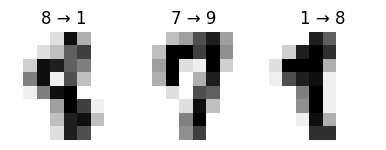

In [65]:
wrongs = np.where(y_test != y_test_pred)[0]
print(wrongs.shape)

for idx, i in enumerate(wrongs):
    plt.subplot(2, 4, idx + 1)
    plt.axis('off')
    plt.imshow(X_test[i].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("%i → %i" % (y_test[i], y_test_pred[i]))

plt.show()

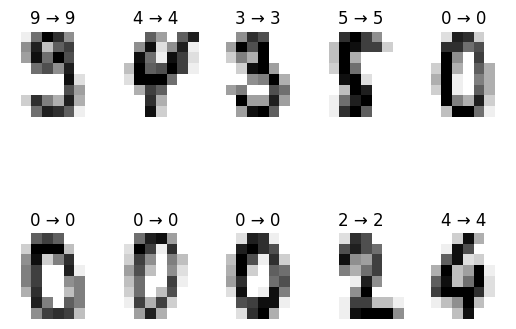

In [66]:
for i, image in enumerate(X_test[:10]):
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    plt.imshow(image.reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("%i → %i" % (y_test[i], y_test_pred[i]))

plt.show()